In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde

In [95]:
from tqdm.notebook import tqdm
import seaborn as sns

### read data and subset accident columns

In [3]:
data = pd.read_csv("../data/US_Accidents_Dec21_updated 2.csv")
data["Airport_Code"].nunique()

2004

In [4]:
weather_columns = list(data.columns[21:29])
weather_columns

['Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Precipitation(in)']

In [5]:
data.index = pd.to_datetime(data["Weather_Timestamp"])
weather_data = data[["Airport_Code"]+weather_columns].drop(columns=["Wind_Direction","Wind_Chill(F)"])
weather_data["Airport_Code"].nunique()

2004

In [6]:
weather_data["mon"] = weather_data.index.month
weather_data["hour"] = weather_data.index.hour
weather_data["hr_session"] = np.where(weather_data["hour"].between(9,21),"day","night")
weather_data["season"] = np.where(weather_data["mon"].isin([6,7,8,9]),"summer","winter")
weather_data["time_ad"] = weather_data["season"] + "_" + weather_data["hr_session"]

In [7]:
weather_data_clean = weather_data.dropna()

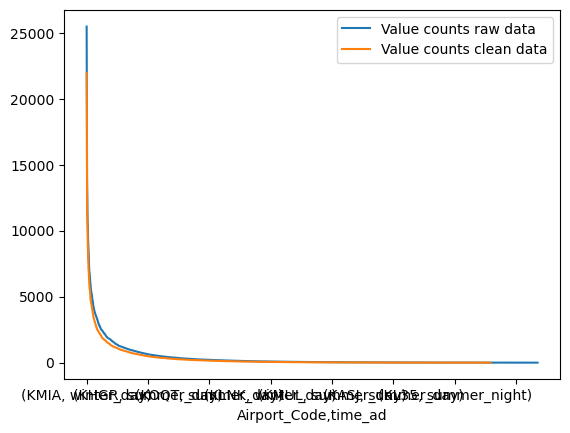

In [8]:
weather_data[["Airport_Code","time_ad"]].value_counts().plot(label="Value counts raw data")
weather_data_clean[["Airport_Code","time_ad"]].value_counts().plot(label="Value counts clean data")
plt.legend()

https://stats.stackexchange.com/a/140986/164155

Basis the above we need atleast 19 points for relaible 2d KDE

In [14]:
(weather_data["Airport_Code"].value_counts()>=25).sum()

1538

In [15]:
weather_data["Airport_Code"].value_counts().sum()

2835793

In [16]:
weather_data[["Airport_Code","time_ad"]].value_counts().sum()

2835793

### KDE estimate for these airports

In [31]:
kde_val_cnt = weather_data_clean[["Airport_Code","time_ad"]].value_counts()
kde_valid = set(x[0] for x in kde_val_cnt[kde_val_cnt>=25].index)
len(kde_valid)

1178

In [139]:
def get_kde(df_airport,airport_i):
    kde_dict ={}
    time_steps = ["summer_day","summer_night","winter_day","winter_night"]
    for time_i in time_steps:
        df_airport_time = df_airport.loc[df_airport.time_ad == time_i]
        try:
            kernel_i = gaussian_kde(df_airport_time[["pca_0","pca_1"]].values.T)
            kde_dict[time_i] = kernel_i
        except:
            print (f"error for {airport_i} {time_i}")
    return kde_dict

def pca_kde_airport(df_airport,airport_i):
    #Do PCA
    assert df_airport.isna().sum().sum()==0, "Airport df has missing values"
    df_airport = df_airport.sort_index()
    weather_cols = df_airport.columns[2:8]
    X = df_airport[weather_cols].values
    try:
        pca = PCA(n_components=2)
        df_airport[["pca_0","pca_1"]] = pca.fit_transform(X)
    except:
        print (f"error in PCA for {airport_i}")
        return df_aiport,{"pca":None, "kde":None}
    #Do KDE
    try:
        kde_dict = get_kde(df_airport,airport_i)
    except:
        print (f"error in KDE for {airport_i}")
        kde_dict = None
    return df_airport,{"pca":pca, "kde":kde_dict}

In [140]:
df_airport = weather_data_clean.loc[weather_data_clean.Airport_Code=="KFDY"]
df_airport,_ = pca_kde_airport(df_airport,airport_i)
# get_kde(df_airport)

error for KDAB summer_night


In [141]:
from joblib import Parallel, delayed

In [167]:
def parallel_func(airport_i):
    df_airport = weather_data_clean.loc[weather_data_clean.Airport_Code==airport_i]
    # get kde and pca
    df_airport1,kde_single = pca_kde_airport(df_airport,airport_i)
#     result_dict[airport_i] = kde_single
    #save kde figure
    if "pca_0" in df_airport1.columns:
        try:
            sns.kdeplot(data=df_airport1, x="pca_0", y="pca_1",
                    fill=True,alpha=0.5,hue="time_ad",bw_adjust=1,warn_singular=False)
            plt.title("$\mathcal{P}(weather|location=KOSU,time=time\_ad)$")
            plt.savefig(f"../data/kde_accidents/{airport_i}_kde_accidents.png")
            plt.close()
        except:
            print (f"Error for saving KDE {airport_i}")
#             return None
    return {airport_i:kde_single}

In [168]:
parallel_result = Parallel(n_jobs=6, verbose = 20, backend = "threading")(delayed(parallel_func,)(airport_i)\
                                                   for airport_i in tqdm(kde_valid))

  0%|          | 0/1178 [00:00<?, ?it/s]

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    2.3s


error for KFDY summer_night


[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    4.0s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    4.7s


error for KARA summer_night


[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    5.1s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    5.7s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    5.9s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    6.6s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    7.6s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    7.9s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    8.4s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    9.2s
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:    9.5s
[Parallel(n_jobs=6)]: Done  16 tasks      | elapsed:    9.8s


error for KPUW summer_night


[Parallel(n_jobs=6)]: Done  17 tasks      | elapsed:   10.3s
[Parallel(n_jobs=6)]: Done  18 tasks      | elapsed:   11.2s
[Parallel(n_jobs=6)]: Done  19 tasks      | elapsed:   11.4s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   11.9s
[Parallel(n_jobs=6)]: Done  21 tasks      | elapsed:   12.3s
[Parallel(n_jobs=6)]: Done  22 tasks      | elapsed:   13.0s
[Parallel(n_jobs=6)]: Done  23 tasks      | elapsed:   13.7s
[Parallel(n_jobs=6)]: Done  24 tasks      | elapsed:   14.0s
[Parallel(n_jobs=6)]: Done  25 tasks      | elapsed:   14.8s
[Parallel(n_jobs=6)]: Done  26 tasks      | elapsed:   15.7s
[Parallel(n_jobs=6)]: Done  27 tasks      | elapsed:   16.3s
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:   16.8s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=6)]: Done  30 tasks      | elapsed:   18.7s
[Parallel(n_jobs=6)]: Done  31 tasks      | elapsed:   20.0s
[Parallel(n_jobs=6)]: Done  32 tasks      | elapsed:   20.0s
[Parallel(n_jobs=6)]: Do

error for KEDE summer_night


[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed:   33.1s
[Parallel(n_jobs=6)]: Done  57 tasks      | elapsed:   33.5s
[Parallel(n_jobs=6)]: Done  58 tasks      | elapsed:   34.3s
[Parallel(n_jobs=6)]: Done  59 tasks      | elapsed:   34.7s


error for KOCW summer_night


[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   35.1s
[Parallel(n_jobs=6)]: Done  61 tasks      | elapsed:   36.1s
[Parallel(n_jobs=6)]: Done  62 tasks      | elapsed:   36.5s
[Parallel(n_jobs=6)]: Done  63 tasks      | elapsed:   36.8s
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:   37.2s
[Parallel(n_jobs=6)]: Done  65 tasks      | elapsed:   37.6s
[Parallel(n_jobs=6)]: Done  66 tasks      | elapsed:   40.3s
[Parallel(n_jobs=6)]: Done  67 tasks      | elapsed:   40.6s
[Parallel(n_jobs=6)]: Done  68 tasks      | elapsed:   41.0s


error for KVER summer_night


[Parallel(n_jobs=6)]: Done  69 tasks      | elapsed:   42.0s
[Parallel(n_jobs=6)]: Done  70 tasks      | elapsed:   42.2s


error for KDCY summer_night


[Parallel(n_jobs=6)]: Done  71 tasks      | elapsed:   42.7s
[Parallel(n_jobs=6)]: Done  72 tasks      | elapsed:   43.1s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   43.9s
[Parallel(n_jobs=6)]: Done  74 tasks      | elapsed:   44.2s
[Parallel(n_jobs=6)]: Done  75 tasks      | elapsed:   44.6s
[Parallel(n_jobs=6)]: Done  76 tasks      | elapsed:   45.1s
[Parallel(n_jobs=6)]: Done  77 tasks      | elapsed:   45.7s
[Parallel(n_jobs=6)]: Done  78 tasks      | elapsed:   46.8s
[Parallel(n_jobs=6)]: Done  79 tasks      | elapsed:   47.0s
[Parallel(n_jobs=6)]: Done  80 tasks      | elapsed:   47.6s
[Parallel(n_jobs=6)]: Done  81 tasks      | elapsed:   48.0s
[Parallel(n_jobs=6)]: Done  82 tasks      | elapsed:   48.3s
[Parallel(n_jobs=6)]: Done  83 tasks      | elapsed:   48.7s
[Parallel(n_jobs=6)]: Done  84 tasks      | elapsed:   49.3s
[Parallel(n_jobs=6)]: Done  85 tasks      | elapsed:   49.5s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:   50.5s
[Parallel(n_jobs=6)]: Do

error for KUXL summer_night


[Parallel(n_jobs=6)]: Done 135 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 138 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:  1.4min


error for KMCW summer_night


[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 151 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 152 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 153 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 155 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 156 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 157 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 159 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 160 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 161 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 162 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 163 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Do

error for K4BM summer_night


[Parallel(n_jobs=6)]: Done 187 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 189 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 190 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 191 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 193 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 194 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 195 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 197 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 198 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 199 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 200 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 201 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 202 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Do

Error for saving KDE KDRA


[Parallel(n_jobs=6)]: Done 211 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 212 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 213 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 214 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 215 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 216 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 217 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 218 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 219 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 221 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 222 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 223 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 224 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 225 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 226 tasks      | elapsed:  2.2min


error for KOAJ summer_night
error for KOAJ winter_night


[Parallel(n_jobs=6)]: Done 227 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 228 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 229 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 230 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 231 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 232 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 233 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 234 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 235 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 236 tasks      | elapsed:  2.3min


error for KY19 summer_night


[Parallel(n_jobs=6)]: Done 237 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 238 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 239 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 240 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 241 tasks      | elapsed:  2.4min


error for KGSH summer_night


[Parallel(n_jobs=6)]: Done 242 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 243 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 244 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 245 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 246 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 247 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 248 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 249 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 250 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 251 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 252 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 253 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 254 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 255 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 256 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 257 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Do

error for KNHK summer_day
error for KNHK summer_night


[Parallel(n_jobs=6)]: Done 262 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 263 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 264 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 265 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 266 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 267 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 268 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 269 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 270 tasks      | elapsed:  2.6min


error for KCMS summer_night


[Parallel(n_jobs=6)]: Done 271 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 272 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 273 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 274 tasks      | elapsed:  2.6min


error for KGLH summer_night


[Parallel(n_jobs=6)]: Done 275 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 277 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 278 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 279 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 280 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 281 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 282 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 283 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 284 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 285 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 286 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 287 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 288 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 289 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 290 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Do

error for KELD summer_night


[Parallel(n_jobs=6)]: Done 304 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 305 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 306 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 307 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 308 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 309 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 310 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 311 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 312 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 313 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 314 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 315 tasks      | elapsed:  3.1min


error for K4A6 summer_night


[Parallel(n_jobs=6)]: Done 316 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 317 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 318 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 319 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 320 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 321 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 322 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 323 tasks      | elapsed:  3.2min


error for KRUT summer_night


[Parallel(n_jobs=6)]: Done 324 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 325 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 326 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 327 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 328 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 329 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 330 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 331 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 332 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 333 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 334 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 335 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 336 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 337 tasks      | elapsed:  3.3min


error for K5H4 summer_night


[Parallel(n_jobs=6)]: Done 338 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 339 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 340 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 341 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 342 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 343 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 344 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 345 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 346 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 347 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 348 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 349 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 350 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 351 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 352 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Do

error for KHNR summer_night


[Parallel(n_jobs=6)]: Done 355 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 356 tasks      | elapsed:  3.5min


error for KBIX summer_night


[Parallel(n_jobs=6)]: Done 357 tasks      | elapsed:  3.5min


error for KGUC summer_night


[Parallel(n_jobs=6)]: Done 358 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 359 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 360 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 361 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 362 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 363 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 365 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 366 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 367 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 368 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 369 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 370 tasks      | elapsed:  3.6min


error for KCPW summer_day
error for KCPW summer_night


[Parallel(n_jobs=6)]: Done 371 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 372 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 373 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 374 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 375 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done 376 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 377 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 378 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 379 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 380 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 381 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 382 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 383 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 384 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 385 tasks      | elapsed:  3.8min


error for KDMN summer_day


[Parallel(n_jobs=6)]: Done 386 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 387 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 388 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 389 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 390 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 391 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 392 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 393 tasks      | elapsed:  3.9min


error for KL35 summer_night


[Parallel(n_jobs=6)]: Done 394 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 395 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 396 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 397 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 398 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 399 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 400 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 401 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 402 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 403 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 404 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 405 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 406 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 407 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 408 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 409 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Do

error for KIDI summer_night


[Parallel(n_jobs=6)]: Done 412 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 413 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 414 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 415 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 416 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 417 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 418 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 419 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 420 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 421 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 422 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 423 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 424 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 425 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 426 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done 427 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Do

error for KGUP summer_night


[Parallel(n_jobs=6)]: Done 429 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 430 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 431 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 432 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 433 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 435 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 436 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 437 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 439 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 440 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 441 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 442 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 443 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 444 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Do

error for KALN summer_night


[Parallel(n_jobs=6)]: Done 458 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 459 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 460 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 461 tasks      | elapsed:  4.6min


error for KRNP summer_night


[Parallel(n_jobs=6)]: Done 462 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 463 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 464 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 465 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 466 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 467 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 468 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 469 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 470 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 471 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 472 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 473 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 474 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 475 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 476 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 477 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Do

error for KLXN summer_night
error for KRWL summer_night


[Parallel(n_jobs=6)]: Done 481 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 482 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 483 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 484 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 485 tasks      | elapsed:  4.8min


error for KCWI summer_night


[Parallel(n_jobs=6)]: Done 486 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 487 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 488 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 489 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 490 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 491 tasks      | elapsed:  4.8min
[Parallel(n_jobs=6)]: Done 492 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 493 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 494 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 495 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 496 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 497 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 498 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 499 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 501 tasks      | elapsed:  4.9min


error for KRMG summer_night


[Parallel(n_jobs=6)]: Done 502 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 503 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 504 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 505 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 506 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 507 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 508 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 509 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 510 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 511 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done 512 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 513 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 514 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 515 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 516 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 517 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Do

error for KLPR summer_night


[Parallel(n_jobs=6)]: Done 556 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 557 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 558 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done 559 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 560 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 561 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 562 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 563 tasks      | elapsed:  5.7min


error for KW22 summer_night


[Parallel(n_jobs=6)]: Done 564 tasks      | elapsed:  5.7min


error for KMYL summer_night


[Parallel(n_jobs=6)]: Done 565 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 566 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 567 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 568 tasks      | elapsed:  5.8min


error for KCTD summer_night


[Parallel(n_jobs=6)]: Done 569 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 570 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 571 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 572 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 573 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 574 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 575 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 576 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 577 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 578 tasks      | elapsed:  5.8min
[Parallel(n_jobs=6)]: Done 579 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 580 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 581 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 582 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 583 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 584 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Do

error for KOTM summer_night


[Parallel(n_jobs=6)]: Done 620 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 621 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done 622 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 623 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 624 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 625 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 626 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 627 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 628 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 629 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 630 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 631 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 632 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 633 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 634 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 635 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Do

error for KVWU summer_night


[Parallel(n_jobs=6)]: Done 672 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 673 tasks      | elapsed:  6.7min
[Parallel(n_jobs=6)]: Done 674 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 675 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 676 tasks      | elapsed:  6.8min


error for KIRS summer_night


[Parallel(n_jobs=6)]: Done 677 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 678 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 679 tasks      | elapsed:  6.8min


error for KGTB summer_night
error for KGTB winter_night


[Parallel(n_jobs=6)]: Done 680 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 681 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 682 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 683 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 684 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 685 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 686 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 687 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 688 tasks      | elapsed:  6.9min


error for KJFZ summer_night


[Parallel(n_jobs=6)]: Done 689 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 690 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 691 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 692 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 693 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 694 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 695 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 696 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 697 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 698 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 699 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 700 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 701 tasks      | elapsed:  7.0min


error for KY70 summer_night


[Parallel(n_jobs=6)]: Done 702 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 703 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 704 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 705 tasks      | elapsed:  7.0min
[Parallel(n_jobs=6)]: Done 706 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 707 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 708 tasks      | elapsed:  7.1min


error for KGKJ summer_day


[Parallel(n_jobs=6)]: Done 709 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 710 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 711 tasks      | elapsed:  7.1min


error for KS14 summer_night


[Parallel(n_jobs=6)]: Done 712 tasks      | elapsed:  7.1min


error for KALX summer_day


[Parallel(n_jobs=6)]: Done 713 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 714 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 715 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 716 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 717 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 718 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 719 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 720 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 721 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 722 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 723 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 724 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 725 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 726 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 727 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 728 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Do

error for KVKS summer_night


[Parallel(n_jobs=6)]: Done 730 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 731 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 732 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 733 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 734 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 735 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 736 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 737 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 738 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 739 tasks      | elapsed:  7.4min
[Parallel(n_jobs=6)]: Done 740 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 741 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 742 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 743 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 744 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 745 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Do

error for KAEX summer_night


[Parallel(n_jobs=6)]: Done 748 tasks      | elapsed:  7.5min


error for KROG summer_night


[Parallel(n_jobs=6)]: Done 749 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 750 tasks      | elapsed:  7.5min
[Parallel(n_jobs=6)]: Done 751 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 752 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 753 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 754 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 755 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 756 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 757 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 758 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 759 tasks      | elapsed:  7.6min
[Parallel(n_jobs=6)]: Done 760 tasks      | elapsed:  7.6min


error for KMSS summer_night
error for KMSS winter_night


[Parallel(n_jobs=6)]: Done 761 tasks      | elapsed:  7.6min


error for KEWB summer_night


[Parallel(n_jobs=6)]: Done 762 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 763 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 764 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 765 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 766 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 767 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 768 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 769 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 770 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 771 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 772 tasks      | elapsed:  7.7min
[Parallel(n_jobs=6)]: Done 773 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 774 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 775 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 776 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 777 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Do

error for KNRB winter_night


[Parallel(n_jobs=6)]: Done 779 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 780 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 781 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 782 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 783 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 784 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 785 tasks      | elapsed:  7.9min


error for KLAR summer_night


[Parallel(n_jobs=6)]: Done 786 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 787 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 789 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 790 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 791 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 792 tasks      | elapsed:  7.9min


error for KWAL summer_night


[Parallel(n_jobs=6)]: Done 793 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 794 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 795 tasks      | elapsed:  7.9min
[Parallel(n_jobs=6)]: Done 796 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 797 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 798 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 799 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 800 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 801 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 802 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 803 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 804 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 805 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 806 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 807 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 808 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Do

error for KBJJ summer_night


[Parallel(n_jobs=6)]: Done 812 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 813 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 814 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 815 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 816 tasks      | elapsed:  8.1min
[Parallel(n_jobs=6)]: Done 817 tasks      | elapsed:  8.1min


error for K20V winter_night


[Parallel(n_jobs=6)]: Done 818 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 819 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 820 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 821 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 822 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 823 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 824 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 825 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 826 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 827 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 828 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 829 tasks      | elapsed:  8.2min


error for KLIC summer_night


[Parallel(n_jobs=6)]: Done 830 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 831 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 832 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 833 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 834 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 835 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 836 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 837 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 838 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 839 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done 840 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 841 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 842 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 843 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 844 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 845 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Do

error for KADU summer_night


[Parallel(n_jobs=6)]: Done 849 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 850 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 851 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 852 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 853 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 854 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 855 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 856 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 857 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 858 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 859 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 860 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 861 tasks      | elapsed:  8.6min


error for KCPR summer_day
error for KCPR summer_night
error for KCPR winter_night


[Parallel(n_jobs=6)]: Done 862 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 863 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 865 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 866 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 867 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 868 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 869 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 870 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 871 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 872 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 873 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 874 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 875 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 876 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Done 877 tasks      | elapsed:  8.7min
[Parallel(n_jobs=6)]: Do

error for KILN summer_night


[Parallel(n_jobs=6)]: Done 880 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 881 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 882 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 883 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 884 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 885 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 886 tasks      | elapsed:  8.8min


error for KMEZ winter_night


[Parallel(n_jobs=6)]: Done 887 tasks      | elapsed:  8.8min
[Parallel(n_jobs=6)]: Done 888 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 889 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 890 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 891 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 892 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 893 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 894 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 895 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 896 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 897 tasks      | elapsed:  8.9min
[Parallel(n_jobs=6)]: Done 898 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 899 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 900 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 901 tasks      | elapsed:  9.0min


error for KPSC summer_night


[Parallel(n_jobs=6)]: Done 902 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 903 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 904 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 905 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done 906 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 907 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 908 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 909 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 910 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 911 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 912 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done 913 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 914 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 915 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 916 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 917 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Do

error for KTBR summer_night


[Parallel(n_jobs=6)]: Done 921 tasks      | elapsed:  9.2min
[Parallel(n_jobs=6)]: Done 922 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 923 tasks      | elapsed:  9.3min


error for KAIO summer_night


[Parallel(n_jobs=6)]: Done 924 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 925 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 926 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 927 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 928 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 929 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 930 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 931 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 932 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 933 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 934 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 935 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 936 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 937 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 938 tasks      | elapsed:  9.4min


error for KEYF winter_night


[Parallel(n_jobs=6)]: Done 939 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 940 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 941 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 942 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 943 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 944 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 945 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 946 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 947 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 948 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 949 tasks      | elapsed:  9.6min


error for KTOL summer_night


[Parallel(n_jobs=6)]: Done 950 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 951 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 952 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 953 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 954 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 955 tasks      | elapsed:  9.6min


error for KINL summer_night


[Parallel(n_jobs=6)]: Done 956 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 957 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 958 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 959 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 960 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 961 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 962 tasks      | elapsed:  9.7min


error for KRKS summer_day
error for KRKS summer_night


[Parallel(n_jobs=6)]: Done 963 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 964 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 965 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 966 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 967 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 968 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 969 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 970 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 971 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 972 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 973 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 974 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 975 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 976 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 977 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 978 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Do

error for KCWV summer_night


[Parallel(n_jobs=6)]: Done 981 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 982 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 983 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 984 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 985 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 986 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 987 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 988 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 989 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 990 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 991 tasks      | elapsed:  9.9min
[Parallel(n_jobs=6)]: Done 992 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 993 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 994 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 995 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done 996 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Do

error for KTVC summer_night


[Parallel(n_jobs=6)]: Done 1006 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 1007 tasks      | elapsed: 10.1min


error for KLNP summer_night


[Parallel(n_jobs=6)]: Done 1008 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 1009 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 1010 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 1011 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 1012 tasks      | elapsed: 10.1min
[Parallel(n_jobs=6)]: Done 1013 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 1014 tasks      | elapsed: 10.2min


error for KASJ summer_night


[Parallel(n_jobs=6)]: Done 1015 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 1016 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 1017 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 1018 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 1019 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 1020 tasks      | elapsed: 10.2min


error for KTWF summer_night


[Parallel(n_jobs=6)]: Done 1021 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 1022 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done 1023 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 1024 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 1025 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 1026 tasks      | elapsed: 10.3min


error for KSMP summer_night


[Parallel(n_jobs=6)]: Done 1027 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 1028 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 1029 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 1030 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 1031 tasks      | elapsed: 10.3min
[Parallel(n_jobs=6)]: Done 1032 tasks      | elapsed: 10.3min


error for KDZJ summer_night


[Parallel(n_jobs=6)]: Done 1033 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 1034 tasks      | elapsed: 10.4min


error for K6B0 summer_night


[Parallel(n_jobs=6)]: Done 1035 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 1036 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 1037 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 1038 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 1039 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 1040 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 1041 tasks      | elapsed: 10.4min
[Parallel(n_jobs=6)]: Done 1042 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 1043 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 1044 tasks      | elapsed: 10.5min


error for KEBS summer_night


[Parallel(n_jobs=6)]: Done 1045 tasks      | elapsed: 10.5min


error for KAJG summer_day
error for KAJG summer_night


[Parallel(n_jobs=6)]: Done 1046 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 1047 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 1048 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 1049 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 1050 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 1051 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 1052 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 1053 tasks      | elapsed: 10.5min
[Parallel(n_jobs=6)]: Done 1054 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 1055 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 1056 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 1057 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 1058 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 1059 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 1060 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done 1061 tasks      | elapsed: 10.6min
[Paralle

error for KHZX summer_night


[Parallel(n_jobs=6)]: Done 1087 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 1088 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 1089 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 1090 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 1091 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 1092 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 1093 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 1094 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 1095 tasks      | elapsed: 10.9min
[Parallel(n_jobs=6)]: Done 1096 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 1097 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 1098 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 1099 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 1100 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 1101 tasks      | elapsed: 11.0min
[Parallel(n_jobs=6)]: Done 1102 tasks      | elapsed: 11.0min
[Paralle

error for K4A9 summer_night


[Parallel(n_jobs=6)]: Done 1134 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done 1135 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 1136 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 1137 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 1138 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 1139 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 1141 tasks      | elapsed: 11.5min


error for KBBB summer_day
error for KBBB summer_night


[Parallel(n_jobs=6)]: Done 1142 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 1143 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 1144 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 1145 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done 1146 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 1147 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 1148 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 1149 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 1150 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 1151 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 1152 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 1153 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 1154 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 1155 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 1156 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done 1157 tasks      | elapsed: 11.7min
[Paralle

error for KSTK summer_night


[Parallel(n_jobs=6)]: Done 1161 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 1162 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 1163 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 1164 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 1165 tasks      | elapsed: 11.7min
[Parallel(n_jobs=6)]: Done 1166 tasks      | elapsed: 11.8min
[Parallel(n_jobs=6)]: Done 1167 tasks      | elapsed: 11.8min


error for KEKM summer_night


[Parallel(n_jobs=6)]: Done 1178 out of 1178 | elapsed: 11.9min finished


In [169]:
len(parallel_result)

1178

In [175]:
parallel_result[0].items()

dict_items([('KHSV', {'pca': PCA(n_components=2), 'kde': {'summer_day': <scipy.stats._kde.gaussian_kde object at 0x1f9779580>, 'summer_night': <scipy.stats._kde.gaussian_kde object at 0x1f9777a00>, 'winter_day': <scipy.stats._kde.gaussian_kde object at 0x1f9777d90>, 'winter_night': <scipy.stats._kde.gaussian_kde object at 0x1f9777d60>}})])

In [185]:
result_dict={}

for x in parallel_result:
    for k,v in x.items():
        result_dict[k]=v

In [187]:
import pickle

with open('../data/accidents_kde.pickle', 'wb') as handle:
    pickle.dump(result_dict, handle)

In [146]:
# result_dict = {}
# for airport_i in tqdm(kde_valid):
#     df_airport = weather_data_clean.loc[weather_data_clean.Airport_Code==airport_i]
#     # get kde and pca
#     df_airport1,kde_single = pca_kde_airport(df_airport,airport_i)
#     result_dict[airport_i] = kde_single
#     #save kde figure
#     if "pca_0" in df_airport1.columns:
#         sns.kdeplot(data=df_airport1, x="pca_0", y="pca_1",
#                     fill=True,alpha=0.5,hue="time_ad",bw_adjust=1)
#         plt.title("$\mathcal{P}(weather|location=KOSU,time=time\_ad)$")
#         plt.savefig(f"../data/kde_accidents/{airport_i}_kde_accidents.png")
#         plt.close()